In [261]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

In [262]:
transport = pd.read_csv("dataset.csv")

In [263]:

transport.describe()
transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ID              1048575 non-null  object 
 1   travel_fee      1048575 non-null  float64
 2   departure_time  1048575 non-null  object 
 3   departure_long  1048575 non-null  float64
 4   departure_lat   1048575 non-null  float64
 5   arrival_long    1048561 non-null  float64
 6   arrival_lat     1048561 non-null  float64
 7   occupancy       1048575 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 64.0+ MB


Data Preprocessing

In [264]:
sample_size = 50000
transport = transport.sample(n=sample_size)


travelfee_train, travelfee_test = train_test_split(transport, test_size=0.2, random_state=42)

print("Length of travelfee_train:", len(travelfee_train))
print("Length of travelfee_test:", len(travelfee_test))

Length of travelfee_train: 40000
Length of travelfee_test: 10000


In [265]:
#check is there any data is null value
travelfee_train.isnull().sum()

ID                0
travel_fee        0
departure_time    0
departure_long    0
departure_lat     0
arrival_long      2
arrival_lat       2
occupancy         0
dtype: int64

In [266]:
#handling missing value
travelfee_train["departure_long"].fillna(travelfee_train["departure_long"].mean(), inplace=True)
travelfee_train["departure_lat"].fillna(travelfee_train["departure_lat"].mean(), inplace=True)
travelfee_train["occupancy"].fillna(travelfee_train["occupancy"].mode()[0], inplace=True)
travelfee_train.drop(columns=['ID'], inplace=True)

# Drop rows with missing "departure_time","arrival_long" and "arrival_lat"
travelfee_train.dropna(subset=["departure_time", "arrival_long", "arrival_lat"],inplace = True)
travelfee_train.isnull().sum()

# Drop rows with a 0 value of occupancy
travelfee_train = travelfee_train.drop(travelfee_train[travelfee_train['occupancy'] <= 0].index)

# Handling Outliers
# Select columns for numeric attributes
num_attribs = ['departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'occupancy', 'travel_fee']

# Remove outliers using Z-score method
z_scores = np.abs((travelfee_train[num_attribs] - travelfee_train[num_attribs].mean()) / travelfee_train[num_attribs].std())
travelfee_train = travelfee_train[(z_scores < 3).all(axis=1)]
travelfee_train.info()
travelfee_train

# Filter out rows with 0 values in departure_long, departure_lat, arrival_long, and arrival_lat
travelfee_train = travelfee_train[
    (travelfee_train["departure_long"] != 0) &
    (travelfee_train["departure_lat"] != 0) &
    (travelfee_train["arrival_long"] != 0) &
    (travelfee_train["arrival_lat"] != 0)
]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36772 entries, 898892 to 646246
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   travel_fee      36772 non-null  float64
 1   departure_time  36772 non-null  object 
 2   departure_long  36772 non-null  float64
 3   departure_lat   36772 non-null  float64
 4   arrival_long    36772 non-null  float64
 5   arrival_lat     36772 non-null  float64
 6   occupancy       36772 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 2.2+ MB


In [267]:
# Convert departure_time to datetime
travelfee_train['departure_time'] = pd.to_datetime(travelfee_train['departure_time'])

# Extract features from departure_time
travelfee_train['hour_of_day'] = travelfee_train['departure_time'].dt.hour
travelfee_train['day_of_week'] = travelfee_train['departure_time'].dt.dayofweek

# Calculate Euclidean distance between departure and arrival locations
travelfee_train['distance'] = travelfee_train.apply(lambda row: euclidean((row['departure_lat'], row['departure_long']),
                                                             (row['arrival_lat'], row['arrival_long'])), axis=1)

In [268]:
travelfee_train.info()
travelfee_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36772 entries, 898892 to 646246
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   travel_fee      36772 non-null  float64            
 1   departure_time  36772 non-null  datetime64[ns, UTC]
 2   departure_long  36772 non-null  float64            
 3   departure_lat   36772 non-null  float64            
 4   arrival_long    36772 non-null  float64            
 5   arrival_lat     36772 non-null  float64            
 6   occupancy       36772 non-null  int64              
 7   hour_of_day     36772 non-null  int64              
 8   day_of_week     36772 non-null  int64              
 9   distance        36772 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(3)
memory usage: 3.1 MB


,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy,hour_of_day,day_of_week,distance
898892,7.5,2013-01-24 07:09:26+00:00,-73.994016,40.761683,-73.974202,40.762302,1,7,3,0.019824
910605,11.0,2013-07-26 08:42:00+00:00,-73.940060,40.750955,-73.971548,40.758067,5,8,4,0.032281
46667,9.5,2013-12-10 16:56:42+00:00,-73.988548,40.768917,-73.982652,40.750842,2,16,1,0.019012
28849,19.5,2013-12-07 11:38:22+00:00,-73.985335,40.723872,-73.958101,40.670357,1,11,5,0.060046
761025,5.0,2013-12-22 21:59:44+00:00,-73.954405,40.778749,-73.945963,40.778430,1,21,6,0.008448


In [269]:
travelfee = travelfee_train[['hour_of_day', 'day_of_week','occupancy','distance']]
travelfee_labels = travelfee_train["travel_fee"].copy()
x3_train, x3_test, y3_train, y3_test = train_test_split(travelfee, travelfee_labels, test_size=0.2, random_state=42)

In [270]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = [ 'hour_of_day', 'day_of_week','occupancy','distance' ]

num_pipeline = make_pipeline(
    StandardScaler()  # Scale features
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    # Apply numeric pipeline to numeric attributes
])

In [271]:
transport_prepared_3 = preprocessing.fit_transform(travelfee)
transport_prepared_3

array([[-1.00975629, -0.02147445, -0.49653384, -0.19287489],
       [-0.85662208,  0.48996234,  3.11526424,  0.02343323],
       [ 0.3684516 , -1.04434801,  0.40641568, -0.20696278],
       ...,
       [ 0.98098845, -0.02147445, -0.49653384, -0.00707566],
       [-2.08169576,  1.5128359 , -0.49653384, -0.0318405 ],
       [-0.85662208, -0.02147445, -0.49653384, -0.18788444]])

In [272]:
preprocessing.get_feature_names_out()

array(['num__hour_of_day', 'num__day_of_week', 'num__occupancy',
       'num__distance'], dtype=object)

In [273]:
transport.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 641531 to 797327
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              50000 non-null  object 
 1   travel_fee      50000 non-null  float64
 2   departure_time  50000 non-null  object 
 3   departure_long  50000 non-null  float64
 4   departure_lat   50000 non-null  float64
 5   arrival_long    49998 non-null  float64
 6   arrival_lat     49998 non-null  float64
 7   occupancy       50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.4+ MB


## **Lasso Regression**
Lasso Regression is a popular technique used in statistical modeling and machine learning to estimate the relationships between variables and make predictions.It is a type of linear regression that uses shrinkage, where data values are shrunk towards a central point, like the mean.This particular type of regression is well-suited for models showing high levels of multicollinearity or when to automate certain parts of model selection, like variable selection/parameter elimination



In [274]:
from sklearn.linear_model import Lasso

lasso_reg = make_pipeline(
    preprocessing,
    Lasso(alpha=0.01,random_state=42)

)


In [275]:
lasso_mse_scores = -cross_val_score(lasso_reg, x3_train, y3_train, scoring="neg_mean_squared_error", cv=5)
lasso_rmse_scores = np.sqrt(lasso_mse_scores)

In [276]:
lasso_mse = lasso_mse_scores.mean()

# Print MSE and RMSE scores
print("Lasso Regression Mean Squared Error (MSE):", lasso_mse)
print("Lasso Regression RMSE Scores:", lasso_rmse_scores)
print("Mean RMSE:", lasso_rmse_scores.mean())
print("Standard Deviation of RMSE:", lasso_rmse_scores.std())

Lasso Regression Mean Squared Error (MSE): 50.26152989845524
Lasso Regression RMSE Scores: [6.32483931 7.37616651 8.83226039 6.26228347 6.29850831]
Mean RMSE: 7.018811598783718
Standard Deviation of RMSE: 0.9989062214414234


## **Logistic Regression**
Logistic regression is a statistical model used for classification and predictive analytics. It estimates the probability of an event occurring based on a given dataset of independent variables.Logistic regression can also be used in machine learning as a supervised algorithm mainly used for classification tasks where the goal is to predict the probability that an instance belongs to a given class.

In [277]:
# Create categorical bins for travel_fee
travelfee_train['fee_category'] = pd.cut(travelfee_train['travel_fee'], bins=[0, 10, 20, 30, 40],
                                         labels=['Low', 'Medium', 'High', 'Very High'])

In [278]:
# Extract features and labels
features = ['hour_of_day', 'day_of_week', 'occupancy', 'distance']
X = travelfee_train[features]
y = travelfee_train['fee_category']

In [279]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [280]:
# Preprocessing pipeline
num_pipeline = make_pipeline(StandardScaler())
preprocessing = ColumnTransformer([
    ("num", num_pipeline, features)
])

# Create a logistic regression pipeline
log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=42))

In [281]:
log_scores = cross_val_score(log_reg, X, y_encoded, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", log_scores)
print("Mean Accuracy:", log_scores.mean())
print("Standard Deviation:", log_scores.std())

Cross-Validation Accuracy Scores: [0.80883753 0.79836846 0.79589339 0.79834104 0.78596682]
Mean Accuracy: 0.7974814466689604
Standard Deviation: 0.00728827470908398


## **Fine tune the short-listed models**


**<u>Lasso Regression Fine Tuning</u>**

In [282]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


lasso_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("lasso", Lasso(random_state=42))
])

lasso_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['hour_of_day', 'day_of_week',
                                                   'occupancy',
                                                   'distance'])])),
                ('lasso', Lasso(random_state=42))])

In [283]:
lasso_param_grid = {"lasso__alpha": [0.01, 0.1, 1, 10]}
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid,scoring='neg_mean_squared_error', cv=10)
lasso_grid_search.fit(x3_train, y3_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['hour_of_day',
                                                                          'day_of_week',
                                                                          'occupancy',
                                                                          'distance'])])),
                                       ('lasso', Lasso(random_state=42))]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1, 10]},
             scoring='neg_mean_squared_error')

In [284]:
# Print the best hyperparameters and best score
print("Best Parameters for Lasso Regression:", lasso_grid_search.best_params_)
print("Best Score for Lasso Regression:", lasso_grid_search.best_score_)

# Get the best Lasso Regression model from grid search
best_lasso_model = lasso_grid_search.best_estimator_

# Calculate RMSE using the best model
lasso_predictions = best_lasso_model.predict(x3_test)
lasso_rmse = np.sqrt(mean_squared_error(y3_test, lasso_predictions))
print("Root Mean Squared Error (RMSE) using the best Lasso model:", lasso_rmse)

Best Parameters for Lasso Regression: {'lasso__alpha': 1}
Best Score for Lasso Regression: -50.20988759388598
Root Mean Squared Error (RMSE) using the best Lasso model: 6.674160808571029


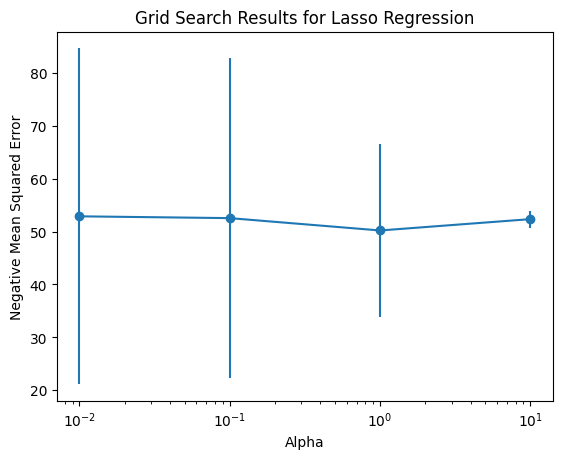

In [285]:
import matplotlib.pyplot as plt

# Extract the grid search results
results = lasso_grid_search.cv_results_
alphas = lasso_param_grid['lasso__alpha']
neg_mse_means = -results['mean_test_score']
neg_mse_stds = results['std_test_score']

# Plot the mean negative MSE with error bars
plt.errorbar(alphas, neg_mse_means, yerr=neg_mse_stds, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error')
plt.title('Grid Search Results for Lasso Regression')
plt.xscale('log')  # Use a logarithmic scale for x-axis
plt.show()

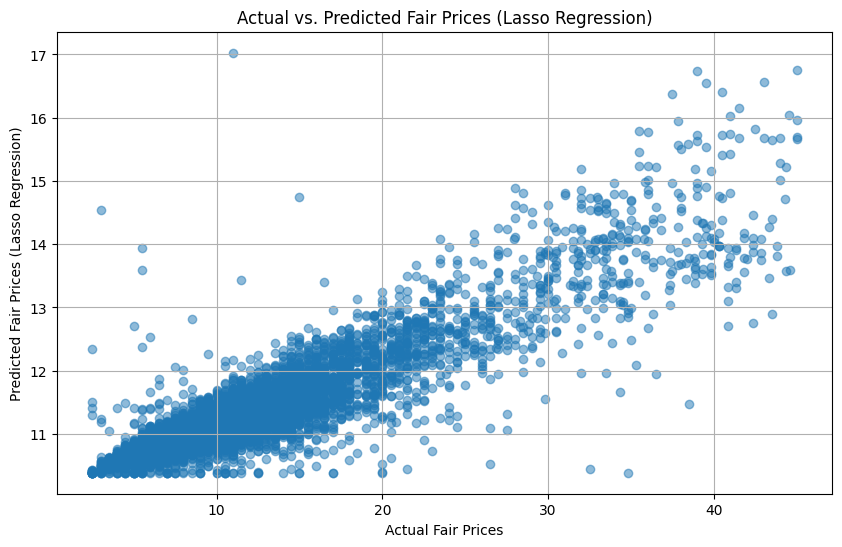

In [286]:
lasso_predicted_fair_prices = best_lasso_model.predict(x3_test)  # Replace x3_test with your test data

# Plotting a graph to compare actual vs. predicted fair prices
plt.figure(figsize=(10, 6))
plt.scatter(y3_test, lasso_predicted_fair_prices, alpha=0.5)
plt.xlabel('Actual Fair Prices')
plt.ylabel('Predicted Fair Prices (Lasso Regression)')
plt.title('Actual vs. Predicted Fair Prices (Lasso Regression)')
plt.grid(True)
plt.show()

**<u>Logistic Regression Fine Tuning</u>**

In [287]:
log_full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("log_reg", LogisticRegression(max_iter=2000)),
])

log_full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['hour_of_day', 'day_of_week',
                                                   'occupancy',
                                                   'distance'])])),
                ('log_reg', LogisticRegression(max_iter=2000))])

In [288]:
param_grid = [
    {'log_reg__C': [0.01, 0.1, 1]}
]

grid_log = GridSearchCV(log_full_pipeline, param_grid, cv=2,
                           scoring='accuracy')

grid_log.fit(X,y_encoded)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['hour_of_day',
                                                                          'day_of_week',
                                                                          'occupancy',
                                                                          'distance'])])),
                                       ('log_reg',
                                        LogisticRegression(max_iter=2000))]),
             param_grid=[{'log_reg__C': [0.01, 0.1, 1]}], scoring='accuracy')

In [289]:
print("tuned hpyerparameters :(best parameters) ",grid_log.best_params_)
print("accuracy :",grid_log.best_score_)

tuned hpyerparameters :(best parameters)  {'log_reg__C': 1}
accuracy : 0.794490373109975


In [290]:
# we can apply ensemble learning to make a better classifier
log_final_model = grid_log.best_estimator_ # includes preprocessing

In [291]:
log_final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['hour_of_day', 'day_of_week',
                                                   'occupancy',
                                                   'distance'])])),
                ('log_reg', LogisticRegression(C=1, max_iter=2000))])

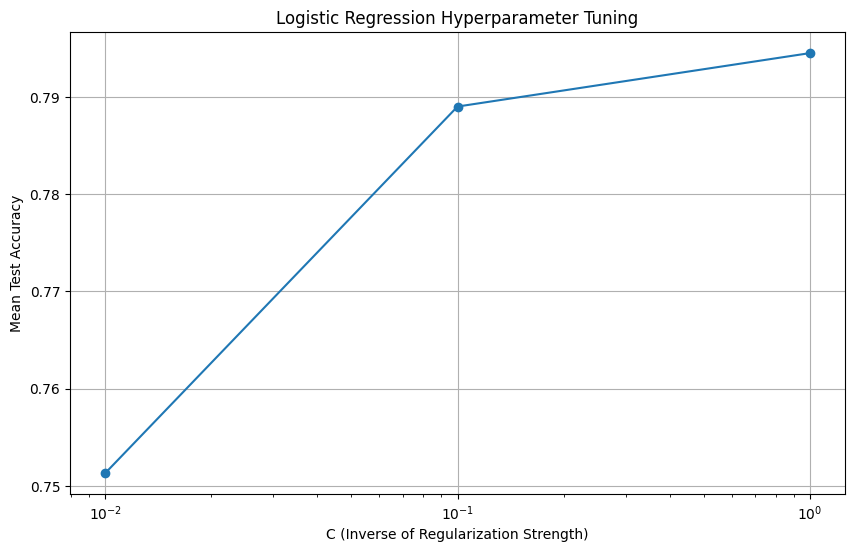

In [292]:
import matplotlib.pyplot as plt

# Extract the hyperparameter values and corresponding mean test scores
param_values = [params['log_reg__C'] for params in grid_log.cv_results_['params']]
mean_test_scores = grid_log.cv_results_['mean_test_score']

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(param_values, mean_test_scores, marker='o')
plt.xscale('log')  # Since the hyperparameter values are on a logarithmic scale
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Logistic Regression Hyperparameter Tuning')
plt.grid(True)
plt.show()